# 1. Import

In [1]:
from __future__ import division
from collections import Counter
## for data
import json
import pandas as pd
import numpy as np
from sklearn import metrics, manifold

## for pre-processing
import re
import nltk
import nltk.corpus
from nltk.corpus import stopwords

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## for language detection
import langdetect
import spacy
from spacy_langdetect import LanguageDetector

## for w2v
import gensim
import gensim.downloader as gensim_api

## for bert
import transformers
from transformers import DistilBertTokenizer, DistilBertModel
import torch
  

## for predicting
from sklearn.metrics.pairwise import cosine_similarity
import re, nltk
import my_functions as func


/Users/sherlyhartono/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
df = pd.read_csv('tweetBERT.csv')
df

tweet
0     Real Estate Market would crash if there is no ...
1     Concur. My company was 100% "you MUST work in ...
2     Why not ask if we really need that thing? I th...
3     Dear Line Managers, Appraisal your subordinate...
4     I have had more opportunities to work cross-fu...
...                                                 ...
6270  Development work is inherently remote, we migh...
6271  Employers should train your employees in #Cybe...
6272  Washingtonian staff goes on strike after CEO's...
6273  Happy Mother's Day to all the wonderful moms o...
6274  Management Strategies for Developing an Effect...

[6275 rows x 1 columns]

In [3]:
func.print_tweet(df, len(df))

0
Real Estate Market would crash if there is no demand for commercial space. Hybrid work / Remote work works . If we design for it. For decades, Office space worked as space to socialize with fellow human beings. 

1
Concur. My company was 100% "you MUST work in the office" and now they have said that is gone. More importantly many of our leaders have moved remote and we have hired remotely. That is a genie that is REALLY hard to put back in the bottle. 

2
Why not ask if we really need that thing? I think it would be fair that anyone that could work remote was privileged to do so, considering how many essential workers and small businesses got fucked over. Coming to to the office now feels like a teacher telling me to learn cursive 

3
Dear Line Managers, Appraisal your subordinate based on their Job performance and not sentiment ,blood-line , religious group or tribe. #HR #Career #peformanceappraisal #EmployeeExperience #remotework #employees 

4
I have had more opportunities to work

# 2. Clean

In [4]:
# from unidecode import unidecode

def clean_BERT(text, isSentenceEmbed = True):

    ''' Pre process and convert texts to a list of words 
    method inspired by method from eliorc github repo: https://github.com/eliorc/Medium/blob/master/MaLSTM.ipynb'''

    if(isSentenceEmbed == True):
        # sentence embedding, we need hashatag
        text = re.sub(r"[^A-Za-z0-9^,!-?%.\/#'+]", " ", text)
    else:
        # word embedding remove hashtag symbol
        text = re.sub(r"[^A-Za-z0-9^]", " ", text)
        text = re.sub(r"\.", " ", text)
    text = re.sub(r"\+", " plus ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\?", " ? ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r"\s{2,}", " ", text)

    return text



In [5]:
df.tweet = df.tweet.apply(lambda x: clean_BERT(x, True))

In [6]:
func.print_tweet(df,len(df))

0
Real Estate Market would crash if there is no demand for commercial space. Hybrid work / Remote work works . If we design for it. For decades Office space worked as space to socialize with fellow human beings. 

1
Concur. My company was 100% "you MUST work in the office" and now they have said that is gone. More importantly many of our leaders have moved remote and we have hired remotely. That is a genie that is REALLY hard to put back in the bottle. 

2
Why not ask if we really need that thing ? I think it would be fair that anyone that could work remote was privileged to do so considering how many essential workers and small businesses got fucked over. Coming to to the office now feels like a teacher telling me to learn cursive 

3
Dear Line Managers Appraisal your subordinate based on their Job performance and not sentiment blood-line religious group or tribe. #HR #Career #peformanceappraisal #EmployeeExperience #remotework #employees 

4
I have had more opportunities to work cros

In [7]:
# create new df that we need to create our word dictionary 
df_word = df.copy()[0:3000]
df_word = func.remove_end_hashtag(df_word)
df_word.tweet = df.tweet.apply(lambda x: clean_BERT(x, False))


In [8]:
func.print_tweet(df_word,len(df_word))

0
Real Estate Market would crash if there is no demand for commercial space Hybrid work Remote work works If we design for it For decades Office space worked as space to socialize with fellow human beings  

1
Concur My company was 100 you MUST work in the office and now they have said that is gone More importantly many of our leaders have moved remote and we have hired remotely That is a genie that is REALLY hard to put back in the bottle  

2
Why not ask if we really need that thing I think it would be fair that anyone that could work remote was privileged to do so considering how many essential workers and small businesses got fucked over Coming to to the office now feels like a teacher telling me to learn cursive 

3
Dear Line Managers Appraisal your subordinate based on their Job performance and not sentiment blood line religious group or tribe HR Career peformanceappraisal EmployeeExperience remotework employees 

4
I have had more opportunities to work cross functionally and eng

In [9]:
# remove duplicates
df_word = df_word.drop_duplicates(subset=['tweet'], keep='first')

In [10]:
df_word.reset_index(drop = True, inplace = True)


In [11]:
df_word

tweet
0     Real Estate Market would crash if there is no ...
1     Concur My company was 100 you MUST work in the...
2     Why not ask if we really need that thing I thi...
3     Dear Line Managers Appraisal your subordinate ...
4     I have had more opportunities to work cross fu...
...                                                 ...
2990  I am available if a remote work opportunity ar...
2991  It made almost everyone work with limited reso...
2992  I started moving things into my new office ups...
2993  DYK that we have spent more than 5 5 billion m...
2994  Are finance leaders finally loosening the rein...

[2995 rows x 1 columns]

# DistilBERT Word Embedding 

<span style='background-color:Teal'>Create word dictionary<span>

https://medium.com/@dhartidhami/understanding-bert-word-embeddings-7dc4d2ea54ca<br>
    https://medium.com/analytics-vidhya/bert-word-embeddings-deep-dive-32f6214f02bf<br>
https://dzlab.github.io/dltips/en/tensorflow/create-bert-vocab/<br>

# 3. Load and Test DistilBERT

In [15]:
from transformers import DistilBertTokenizerFast

# 1. Instantiate DistilBERT tokenizer...we use the Fast version to optimize runtime
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased', pad_token='[PAD]', model_max_length = 87)

# 2. get word embedder (encoder)
model = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased',output_hidden_states=True)



Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_projector', 'vocab_layer_norm', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [16]:
txt = 'Dear Line Managers Appraisal your subordinate based on their Job performance and not sentiment blood-line religious group or tribe'

# 1. encode
ids = tokenizer.encode(txt, max_length = 87,pad_to_max_length=True,add_special_tokens = True, truncation=True)
print("\nIDs   :\n", ids)

# 2. tokenize with CLS and SEP
tokens = tokenizer.convert_ids_to_tokens(ids)
print("\nTokens with special:\n", tokens)

# 3. Display the words with their IDs.
for tup in zip(tokens, ids ):
    print('{:<12} {:>6,}'.format(tup[0], tup[1]))



IDs   :
 [101, 6203, 2240, 10489, 10439, 14995, 12002, 2115, 15144, 2241, 2006, 2037, 3105, 2836, 1998, 2025, 15792, 2668, 1011, 2240, 3412, 2177, 2030, 5917, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Tokens with special:
 ['[CLS]', 'dear', 'line', 'managers', 'app', '##rai', '##sal', 'your', 'subordinate', 'based', 'on', 'their', 'job', 'performance', 'and', 'not', 'sentiment', 'blood', '-', 'line', 'religious', 'group', 'or', 'tribe', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[P

# 4. Tokenize and Encoding

## 4.1 Encoding and Tokenize Sample

<span style='background-color:Teal'>We first need to get the maximum length of the tweet so we can pad it properly<span>

In [17]:
ids_np = df_word.tweet.apply(lambda x: tokenizer.encode(x))
max_len = 0
for ids in ids_np.values:
    if len(ids) > max_len:
        max_len = len(ids)


In [18]:
max_len

87

In [19]:
# get ids as numpy array
id_ = df_word.tweet.apply(lambda x: tokenizer.encode(x, add_special_tokens = True)) # Add [PAD]s

idJ_np = np.array([i + [0]*(max_len-len(i)) for i in id_.values])

print('\nshape:\n', idJ_np.shape)
print(idJ_np[0])


shape:
 (2995, 87)
[ 101 2613 3776 3006 2052 5823 2065 2045 2003 2053 5157 2005 3293 2686
 8893 2147 6556 2147 2573 2065 2057 2640 2005 2009 2005 5109 2436 2686
 2499 2004 2686 2000 2591 4697 2007 3507 2529 9552  102    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0]


<span style='background-color:Teal'>We want our IDs numpy to be in this format<span>

In [20]:
attention_maskJ = np.where(idJ_np != 0, 1, 0)
print('\nshape:\n',attention_maskJ.shape)
print(attention_maskJ[0])


shape:
 (2995, 87)
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


## 4.2 Encoding to ID

In [21]:
# 1. Encoding
ids_attn = df_word.tweet.apply(lambda x: tokenizer.encode_plus(x,
                                                        add_special_tokens = True,
                                                        max_length =max_len,# maximum length of a sentence
                                                        truncation=True,
                                                        return_tensors = 'np',
                                                        padding = 'max_length')) # Add [PAD]s
print(ids_attn)
  

0       [input_ids, attention_mask]
1       [input_ids, attention_mask]
2       [input_ids, attention_mask]
3       [input_ids, attention_mask]
4       [input_ids, attention_mask]
                   ...             
2990    [input_ids, attention_mask]
2991    [input_ids, attention_mask]
2992    [input_ids, attention_mask]
2993    [input_ids, attention_mask]
2994    [input_ids, attention_mask]
Name: tweet, Length: 2995, dtype: object


In [23]:
# 2. get IDs numpy
input_ids_list = []
for i in range(len(ids_attn)):
    input_ids_list.append(ids_attn[i]['input_ids'][0])

    
input_ids_np = np.array(input_ids_list)



## 4.3 Encoding to Attention_mask

In [24]:
# get Attention_mask numpy

attention_mask_list = []
for i in range(len(ids_attn)):
    attention_mask_list.append(ids_attn[i]['attention_mask'][0])
    
    
attention_mask_np = np.array(attention_mask_list)



In [28]:
# Check that the index match 39 is [SEP] and so 40 is [PAD]
print("input id's shape: ", input_ids_np.shape)
print("attention mask's shape: ", attention_mask_np.shape)

print('\n',input_ids_np[0])
print('\nAt index 39 input id is: ',input_ids_np[0][38])
print('At index 40 input id is: ',input_ids_np[0][39])
print('\nAt Index 39 attention is: ', attention_mask_np[0][38])
print('At Index 40 attention is: ',attention_mask_np[0][39])


input id's shape:  (2995, 87)
attention mask's shape:  (2995, 87)

 [ 101 2613 3776 3006 2052 5823 2065 2045 2003 2053 5157 2005 3293 2686
 8893 2147 6556 2147 2573 2065 2057 2640 2005 2009 2005 5109 2436 2686
 2499 2004 2686 2000 2591 4697 2007 3507 2529 9552  102    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0]

At index 39 input id is:  102
At index 40 input id is:  0

At Index 39 attention is:  1
At Index 40 attention is:  0


## 4.4 Tokenize to words

In [29]:
tokens_np = df_word.tweet.apply(lambda x: tokenizer.tokenize(x,
                                                             add_special_tokens = True,
                                                             max_length = max_len,
                                                             truncation=True,
                                                             return_tensors = 'np',
                                                             pad_to_max_length=True))
tokens_np[0]


['[CLS]',
 'real',
 'estate',
 'market',
 'would',
 'crash',
 'if',
 'there',
 'is',
 'no',
 'demand',
 'for',
 'commercial',
 'space',
 'hybrid',
 'work',
 'remote',
 'work',
 'works',
 'if',
 'we',
 'design',
 'for',
 'it',
 'for',
 'decades',
 'office',
 'space',
 'worked',
 'as',
 'space',
 'to',
 'social',
 '##ize',
 'with',
 'fellow',
 'human',
 'beings',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

# 5. Save IDs, attention_mask, and tokens as DF

## 5.1 Save tokens in Df

In [30]:
tokens_df = pd.DataFrame(tokens_np)
tokens_df.rename(columns = {'tweet': 'tweet_tokens'})
df_word['tokens'] = tokens_df
df_word

tweet  \
0     Real Estate Market would crash if there is no ...   
1     Concur My company was 100 you MUST work in the...   
2     Why not ask if we really need that thing I thi...   
3     Dear Line Managers Appraisal your subordinate ...   
4     I have had more opportunities to work cross fu...   
...                                                 ...   
2990  I am available if a remote work opportunity ar...   
2991  It made almost everyone work with limited reso...   
2992  I started moving things into my new office ups...   
2993  DYK that we have spent more than 5 5 billion m...   
2994  Are finance leaders finally loosening the rein...   

                                                 tokens  
0     [[CLS], real, estate, market, would, crash, if...  
1     [[CLS], con, ##cu, ##r, my, company, was, 100,...  
2     [[CLS], why, not, ask, if, we, really, need, t...  
3     [[CLS], dear, line, managers, app, ##rai, ##sa...  
4     [[CLS], i, have, had, more, opportunities, to,...  
...                                                 ...  
2990  [[CLS], i, am, available, if, a, remote, work,...  
2991  [[CLS], it, made, almost, everyone, work, with...  
2992  [[CLS], i, started, moving, things, into, my, ...  
2993  [[CLS], d, ##yk, that, we, have, spent, more, ...  
2994  [[CLS], are, finance, leaders, finally, loosen...  

[2995 rows x 2 columns]

## 5.2 Save Token Ids as Df

In [31]:
# assign empty list to token ids column: of shape (len(df_word) = 100, max_len = 67 words)
df_word['token_ids'] = np.empty((len(df_word), max_len)).tolist()

# assign token ids 
df_word['token_ids'] = input_ids_list

df_word

tweet  \
0     Real Estate Market would crash if there is no ...   
1     Concur My company was 100 you MUST work in the...   
2     Why not ask if we really need that thing I thi...   
3     Dear Line Managers Appraisal your subordinate ...   
4     I have had more opportunities to work cross fu...   
...                                                 ...   
2990  I am available if a remote work opportunity ar...   
2991  It made almost everyone work with limited reso...   
2992  I started moving things into my new office ups...   
2993  DYK that we have spent more than 5 5 billion m...   
2994  Are finance leaders finally loosening the rein...   

                                                 tokens  \
0     [[CLS], real, estate, market, would, crash, if...   
1     [[CLS], con, ##cu, ##r, my, company, was, 100,...   
2     [[CLS], why, not, ask, if, we, really, need, t...   
3     [[CLS], dear, line, managers, app, ##rai, ##sa...   
4     [[CLS], i, have, had, more, opportunities, to,...   
...                                                 ...   
2990  [[CLS], i, am, available, if, a, remote, work,...   
2991  [[CLS], it, made, almost, everyone, work, with...   
2992  [[CLS], i, started, moving, things, into, my, ...   
2993  [[CLS], d, ##yk, that, we, have, spent, more, ...   
2994  [[CLS], are, finance, leaders, finally, loosen...   

                                              token_ids  
0     [101, 2613, 3776, 3006, 2052, 5823, 2065, 2045...  
1     [101, 9530, 10841, 2099, 2026, 2194, 2001, 253...  
2     [101, 2339, 2025, 3198, 2065, 2057, 2428, 2342...  
3     [101, 6203, 2240, 10489, 10439, 14995, 12002, ...  
4     [101, 1045, 2031, 2018, 2062, 6695, 2000, 2147...  
...                                                 ...  
2990  [101, 1045, 2572, 2800, 2065, 1037, 6556, 2147...  
2991  [101, 2009, 2081, 2471, 3071, 2147, 2007, 3132...  
2992  [101, 1045, 2318, 3048, 2477, 2046, 2026, 2047...  
2993  [101, 1040, 15922, 2008, 2057, 2031, 2985, 206...  
2994  [101, 2024, 5446, 4177, 2633, 29476, 2075, 199...  

[2995 rows x 3 columns]

In [32]:
attention_mask_list

[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

## 5.3 Save attention mask as DF

In [33]:
df_word['attention_mask'] = np.empty((len(df_word),max_len)).tolist()

df_word['attention_mask'] = attention_mask_list

df_word

tweet  \
0     Real Estate Market would crash if there is no ...   
1     Concur My company was 100 you MUST work in the...   
2     Why not ask if we really need that thing I thi...   
3     Dear Line Managers Appraisal your subordinate ...   
4     I have had more opportunities to work cross fu...   
...                                                 ...   
2990  I am available if a remote work opportunity ar...   
2991  It made almost everyone work with limited reso...   
2992  I started moving things into my new office ups...   
2993  DYK that we have spent more than 5 5 billion m...   
2994  Are finance leaders finally loosening the rein...   

                                                 tokens  \
0     [[CLS], real, estate, market, would, crash, if...   
1     [[CLS], con, ##cu, ##r, my, company, was, 100,...   
2     [[CLS], why, not, ask, if, we, really, need, t...   
3     [[CLS], dear, line, managers, app, ##rai, ##sa...   
4     [[CLS], i, have, had, more, opportunities, to,...   
...                                                 ...   
2990  [[CLS], i, am, available, if, a, remote, work,...   
2991  [[CLS], it, made, almost, everyone, work, with...   
2992  [[CLS], i, started, moving, things, into, my, ...   
2993  [[CLS], d, ##yk, that, we, have, spent, more, ...   
2994  [[CLS], are, finance, leaders, finally, loosen...   

                                              token_ids  \
0     [101, 2613, 3776, 3006, 2052, 5823, 2065, 2045...   
1     [101, 9530, 10841, 2099, 2026, 2194, 2001, 253...   
2     [101, 2339, 2025, 3198, 2065, 2057, 2428, 2342...   
3     [101, 6203, 2240, 10489, 10439, 14995, 12002, ...   
4     [101, 1045, 2031, 2018, 2062, 6695, 2000, 2147...   
...                                                 ...   
2990  [101, 1045, 2572, 2800, 2065, 1037, 6556, 2147...   
2991  [101, 2009, 2081, 2471, 3071, 2147, 2007, 3132...   
2992  [101, 1045, 2318, 3048, 2477, 2046, 2026, 2047...   
2993  [101, 1040, 15922, 2008, 2057, 2031, 2985, 206...   
2994  [101, 2024, 5446, 4177, 2633, 29476, 2075, 199...   

                                         attention_mask  
0     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
1     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
2     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
3     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
4     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
...                                                 ...  
2990  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, ...  
2991  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
2992  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
2993  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
2994  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  

[2995 rows x 4 columns]

# 6. Modelling

In [34]:
# get embedded last hidden states
last_hidden_states = model(input_ids_np, attention_mask=attention_mask_np)

In [35]:
last_hidden_states

TFBaseModelOutput(last_hidden_state=<tf.Tensor: shape=(2995, 87, 768), dtype=float32, numpy=
array([[[ 8.88930634e-03, -9.59180892e-02, -8.84914547e-02, ...,
         -5.61629891e-01,  5.93495429e-01,  6.72507808e-02],
        [ 8.43059659e-01,  2.63982773e-01,  3.24904650e-01, ...,
         -5.28788924e-01,  6.05300367e-01, -5.84310517e-02],
        [ 5.30359507e-01, -2.66875714e-01,  7.59798050e-01, ...,
         -4.05066162e-01,  4.11172867e-01, -2.76982963e-01],
        ...,
        [ 4.00410295e-01, -9.01964754e-02,  2.14004755e-01, ...,
         -3.29070061e-01,  5.94906509e-04,  1.97805792e-01],
        [ 4.12079901e-01, -1.21448688e-01,  1.96882874e-01, ...,
         -5.09653464e-02, -1.69267371e-01,  7.81582817e-02],
        [ 4.03621793e-01, -4.64675128e-02,  2.55702913e-01, ...,
         -2.81422615e-01, -1.05160922e-02,  8.32350031e-02]],

       [[ 2.32275888e-01,  1.14029951e-01,  5.78943901e-02, ...,
         -2.00772882e-01,  5.70221007e-01,  1.74348369e-01],
        [ 

# 7. Check our last hidden states

![title](last_hidden.png)

<span style='background-color:Teal'> first  [0] is the Tensor <br>
second [0] is the tweet <br>
third [0] is the word  <br><span>
fourth [0] is the part of tensor of 768  <br><span>

In [36]:
# Lets check the embedding for the word con in the first tweet
con_embed = last_hidden_states[0][1,1]
print(type(con_embed))

con_embed_np = np.array(last_hidden_states[0][1,1])
print(type(con_embed_np))

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'numpy.ndarray'>


In [37]:
print(con_embed_np)

[ 4.07348216e-01 -9.14711207e-02  3.62892747e-01 -1.07710525e-01
  1.44213423e-01  3.91482383e-01 -1.69237584e-01  5.63426137e-01
  2.37991825e-01 -3.24714333e-01 -7.72822052e-02 -1.61245450e-01
  2.03920171e-01  6.00362659e-01 -2.71073252e-01 -9.86448005e-02
  2.03825533e-01  5.78464232e-02  4.93993834e-02  9.21252742e-02
  3.26988727e-01  7.85409436e-02  1.87933505e-01  7.26540089e-01
  4.44400758e-01  3.48569639e-02  1.42891869e-01  6.50949404e-02
  4.78758141e-02 -2.56203562e-01  2.87369281e-01  8.75322372e-02
 -3.50654393e-01 -1.87270254e-01 -6.53729379e-01 -1.93679154e-01
 -2.15548128e-01  1.41803995e-02  2.11388562e-02  2.79871881e-01
 -5.77087924e-02 -1.24298483e-01 -1.43707708e-01  1.62789926e-01
 -3.22297424e-01  4.09327969e-02 -3.19525003e-01 -5.08315444e-01
  7.01587424e-02 -2.02415943e-01 -3.65680188e-01  1.88808665e-01
 -3.58864963e-01 -2.96391193e-02  2.46621013e-01  6.95959806e-01
 -2.16660768e-01  6.41067699e-02 -3.17520857e-01 -1.10203251e-02
  1.78836629e-01 -1.93809

# 8. Test Get embedding for each word in a tweet

In [38]:
sentence_idx = 0
tokens_tweets = df_word.iloc[sentence_idx].tokens
embedding_tweets = last_hidden_states[0][sentence_idx]

print(tokens_tweets)
print(embedding_tweets.shape)

['[CLS]', 'real', 'estate', 'market', 'would', 'crash', 'if', 'there', 'is', 'no', 'demand', 'for', 'commercial', 'space', 'hybrid', 'work', 'remote', 'work', 'works', 'if', 'we', 'design', 'for', 'it', 'for', 'decades', 'office', 'space', 'worked', 'as', 'space', 'to', 'social', '##ize', 'with', 'fellow', 'human', 'beings', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
(87, 768)


## 8.1 Get Words Function

In [ ]:
# def create_word_df(the_tokens_list):   
#     # Part A: words df
#     the_clean_tokens_list = []
#     the_tokens_idx = []
#     merged_tokens_idx = []
#     max_len = len(the_tokens_list)
#     i = 0
#     word = the_tokens_list[i]
#     while(i < max_len):
#         add = True
#         word = the_tokens_list[i]
#         # 1. join ## words first
#         # if its not the last word, 
#         if(i <= (max_len-2)):
#             next_word = the_tokens_list[i+1]
#             pattern = r"(^##)"
#             # if the next word is ##
#             while (bool(re.search(pattern,next_word))):
#                 add = False
#                 print('index of word with ##: ',i+1)
#                 word = word + next_word[2:]
#                 if(i) not in merged_tokens_idx:
#                     merged_tokens_idx.append(i)
#                 merged_tokens_idx.append(i+1)
#                 print('word after merge:', word)
#                 # skip the next word becos we have merged it
#                 i+=1
#                 next_word = the_tokens_list[i+1]
        
#         if(merged_tokens_idx) not in the_tokens_idx:
#             the_tokens_idx.append(merged_tokens_idx) 
#         # 2. get tokens that are not padding, CLS, PAD, SEP, and not in stopwords
#         if(word!= '[CLS]') and (word!= '[PAD]') and (word!= '[SEP]') and (word not in stopwords.words('english')):     
#             the_clean_tokens_list.append(word)
#             if(add == True):
#                 the_tokens_idx.append(i)
                
        
#         # 3. move to next word
#         i+=1
    
#     the_df_dict= pd.DataFrame(the_clean_tokens_list)
#     the_df_dict.columns = ['words']
#     print(merged_tokens_idx)
#     return [the_df_dict ,the_tokens_idx, the_clean_tokens_list]
    
    

In [39]:
def create_word_df(the_tokens_list):   
    the_clean_tokens_list= []
    the_tokens_idx = []
    i = 0
    
    # 1. loop through the token list
    word = the_tokens_list[i]
    for i in range(len(the_tokens_list)):
        word = the_tokens_list[i]
        # 2. If its not specialised token and words are not in stop words:
        if(word!= '[CLS]') and (word!= '[PAD]') and (word!= '[SEP]') and (word not in stopwords.words('english')):     
            the_clean_tokens_list.append(word)
            the_tokens_idx.append(i)     


    the_df_dict= pd.DataFrame(the_clean_tokens_list)
    the_df_dict.columns = ['words']
    return [the_df_dict ,the_tokens_idx, the_clean_tokens_list]
    
    

In [40]:
df_data_dict,tokens_idx,clean_tokens_list  = create_word_df(tokens_tweets)

In [41]:
print(clean_tokens_list)

['real', 'estate', 'market', 'would', 'crash', 'demand', 'commercial', 'space', 'hybrid', 'work', 'remote', 'work', 'works', 'design', 'decades', 'office', 'space', 'worked', 'space', 'social', '##ize', 'fellow', 'human', 'beings']


In [42]:
df_data_dict

words
0         real
1       estate
2       market
3        would
4        crash
5       demand
6   commercial
7        space
8       hybrid
9         work
10      remote
11        work
12       works
13      design
14     decades
15      office
16       space
17      worked
18       space
19      social
20       ##ize
21      fellow
22       human
23      beings

## 8.2 Get Embedding Functions

In [43]:
def create_embedding_df(the_df_dict,the_embeddings_list, the_idx_list):
    clean_embedding_list = []
    
    # 1. loop through tokens_idx 
    for i in range(len(the_idx_list)):
        embed_idx = the_idx_list[i]

        # get the embedding from embedding_list
        clean_embedding_list.append(np.array(the_embeddings_list[embed_idx]))
             
    # 2. numpy form 
    the_embeddings_np = np.array(clean_embedding_list)
    
    # make embeddings:
    # 3. df form
    the_df_dict['embeddings'] = np.empty([len(the_idx_list), 768]).tolist()
    the_df_dict['embeddings'] = clean_embedding_list
    
    return [the_df_dict, the_embeddings_np]
    

In [44]:
df_data_dict, embeddings_np = create_embedding_df(df_data_dict, embedding_tweets, tokens_idx)
df_data_dict

words                                         embeddings
0         real  [0.84305966, 0.26398277, 0.32490465, 0.0248823...
1       estate  [0.5303595, -0.2668757, 0.75979805, 0.19747669...
2       market  [0.28153154, -0.28520963, 0.5332744, 0.2479845...
3        would  [-0.30469832, -0.46680853, -0.14788364, 0.0218...
4        crash  [-0.24616344, 0.039229684, 0.06317264, 0.44311...
5       demand  [-0.023353156, -0.42342252, 0.5526034, 0.37005...
6   commercial  [0.39541495, 0.045803472, 0.3689129, 0.2261642...
7        space  [0.3874065, 0.26115918, 0.47943377, 0.51769924...
8       hybrid  [0.6151819, -0.096116796, 0.3674084, 0.2993512...
9         work  [0.62023395, 0.32893974, 0.21471044, 0.2791845...
10      remote  [0.27713785, 0.09604862, 0.3749234, 0.21903946...
11        work  [0.74644744, 0.26608503, 0.13891439, 0.2153984...
12       works  [0.27266425, 0.4080572, 0.1091492, 0.22392283,...
13      design  [0.7144172, 0.5098092, 0.1734446, 0.11138371, ...
14     decades  [0.44494542, 0.4973481, 0.5729908, 0.36108372,...
15      office  [0.17431077, 0.4084535, 0.5309441, 0.32247835,...
16       space  [0.4548922, 0.54702365, 0.38265187, 0.47731066...
17      worked  [0.09545455, 0.034721848, 0.24111104, 0.299962...
18       space  [0.25372785, 0.27416325, 0.51389885, 0.5055418...
19      social  [0.055819176, 0.4034339, 0.80159146, -0.112323...
20       ##ize  [-0.120131865, 0.27451172, 0.6916206, 0.215925...
21      fellow  [0.45696655, 0.009667327, 0.676628, -0.0595347...
22       human  [0.12850413, 0.29650015, 0.28864783, 0.0889347...
23      beings  [0.4268809, -0.024230275, 0.4151593, 0.1721982...

## 8.3 Get word and embedding for all tweets Functions

In [45]:
def get_words_and_embedding_from_df(the_df):
    
    tokens_list = the_df.iloc[0].tokens
    embedding_list = last_hidden_states[0][0]
    
    final_df_dict, tokens_idx,clean_tokens_list = create_word_df(tokens_tweets)
    final_df_dict, the_embeddings_np = create_embedding_df(final_df_dict, embedding_list, tokens_idx)
    final_df_dict['sentence_idx'] = 0
    
    #for rest of each tweet/ row
    for sentence_idx in range(1,len(the_df)):
        # print(sentence_idx)
        # 1. get list of tokens/words in a tweet
        tokens_list = the_df.iloc[sentence_idx].tokens
        
        # 2. get list of embedding in a tweet
        embedding_list = last_hidden_states[0][sentence_idx]
        
        # 3. get word df
        df_dict, tokens_idx,clean_tokens_list = create_word_df(tokens_list)
        df_dict['sentence_idx'] = int(sentence_idx)
        
        #4. add embeddings columns to the df
        df_dict, the_embeddings_np = create_embedding_df(df_dict, embedding_list, tokens_idx)
        
        
        frames = [final_df_dict, df_dict]

        final_df_dict = pd.concat(frames)
        
        
    return final_df_dict


In [46]:
df_data_dict = get_words_and_embedding_from_df(df_word)

In [47]:
df_data_dict.reset_index(drop = True, inplace = True)
df_data_dict

words                                         embeddings  \
0                real  [0.84305966, 0.26398277, 0.32490465, 0.0248823...   
1              estate  [0.5303595, -0.2668757, 0.75979805, 0.19747669...   
2              market  [0.28153154, -0.28520963, 0.5332744, 0.2479845...   
3               would  [-0.30469832, -0.46680853, -0.14788364, 0.0218...   
4               crash  [-0.24616344, 0.039229684, 0.06317264, 0.44311...   
...               ...                                                ...   
64894  responsibility  [-0.008578587, 0.1220773, 0.24025224, -0.05287...   
64895           staff  [0.31579545, 0.04895662, 0.29348424, -0.167502...   
64896         welfare  [0.20462838, 0.31706288, 0.05414169, -0.091104...   
64897          cannot  [-0.12302854, -0.030138453, 0.32204738, -0.080...   
64898         avoided  [-0.40538037, -0.13855177, -0.17537802, 0.0789...   

       sentence_idx  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0  
...             ...  
64894          2994  
64895          2994  
64896          2994  
64897          2994  
64898          2994  

[64899 rows x 3 columns]

## 8.4 Double check if the embedding created is correct

In [ ]:
# print(df_word.iloc[4999].tokens[52])

# # get the embedding: [tensor][sentence][words][nth value]
# last_hidden_states[0][4999][52][:5]

## 8.6 Convert our embedding column to numpy array ( to prepare for clustering )

In [48]:
# convert Pandas series to numpy array
# convert first to list, then convert to array
embeddings_np = np.array(df_data_dict.embeddings.tolist())
embeddings_np.shape

(64899, 768)

## 8.7 Remove Duplicates

In [49]:
# Question. There are no duplicates, its normal?
embeddings_list = [tuple(row) for row in embeddings_np]
embeddings_unique_np, unique_index = np.unique(embeddings_list,axis = 0, return_index = True)


In [50]:
print(embeddings_unique_np.shape)
unique_index

(64811, 768)


array([48063,  2357, 33747, ...,  7521,  7304, 42472])

<span style='background-color:Teal'>There are 22,071 duplicates. Lets Remove them from df_dict<span>

In [51]:
# 1. convert the numpy array to tupple. 
# 2. apply duplicated() to the tuple
# 3. get the duplicated embeddings
# 4. slice where its not duplicated
df_data_dict = df_data_dict[~df_data_dict['embeddings'].apply(tuple).duplicated()]

In [52]:
df_data_dict.reset_index(drop = True, inplace = True)

# 9. Clustering

<span style='background-color:Teal'> We want to make sure that documents with similar sentiments are clustered together such that we can find the topics within these clusters. Before doing so, we first need to lower the dimensionality of the embeddings as many clustering algorithms handle high dimensionality poorly. <span>

## 9.1 Reduce Dimensionality using UMAP

<span style="background-color:Teal">Out of the few dimensionality reduction algorithms, UMAP is arguably the best performing as it keeps a significant portion of the high-dimensional local structure in lower dimensionality.<span>

In [53]:
embeddings_unique_np

array([[-1.6939174 , -0.19573691,  0.6890526 , ...,  0.09354876,
         0.38326532,  1.2767357 ],
       [-1.6890532 ,  0.06395584, -0.02091985, ..., -0.20890681,
         0.02273284, -0.31984532],
       [-1.6507413 , -0.12008357,  0.3524964 , ...,  0.3366561 ,
         0.16161059, -0.04826396],
       ...,
       [ 1.325975  ,  0.18212044, -0.4822994 , ..., -0.6486587 ,
         0.07846841, -0.1794291 ],
       [ 1.3621334 ,  0.35562846,  0.10385697, ..., -0.1203705 ,
         0.40745148, -0.06035236],
       [ 1.5283575 , -0.11923961,  0.11455644, ..., -0.26723832,
        -0.12943302, -0.00508317]], dtype=float32)

In [54]:
import umap

embeddings_reduced_np = umap.UMAP(n_neighbors=15,
                       n_components=100,
                       metric='cosine').fit_transform(embeddings_unique_np)


In [55]:
embeddings_reduced_np

array([[0.08235257, 9.895063  , 9.975002  , ..., 5.52079   , 6.748969  ,
        6.1416364 ],
       [0.02038195, 9.958928  , 9.984924  , ..., 5.542089  , 6.046724  ,
        6.519245  ],
       [0.0810686 , 9.894433  , 9.975112  , ..., 5.518255  , 6.7291903 ,
        6.137172  ],
       ...,
       [0.02857616, 9.938445  , 9.984564  , ..., 5.529945  , 6.669069  ,
        6.24286   ],
       [0.02790071, 9.959629  , 9.985315  , ..., 5.546293  , 5.764818  ,
        6.60431   ],
       [0.03857856, 9.93899   , 9.982428  , ..., 5.5528717 , 6.5781326 ,
        6.287262  ]], dtype=float32)

## 9.2 Clustering KNN

<span style="background-color:Teal"> After having reduced the dimensionality of the documents embeddings to 5, we can cluster the documents with HDBSCAN. HDBSCAN is a density-based algorithm that works quite well with UMAP since UMAP maintains a lot of local structure even in lower-dimensional space. Moreover, HDBSCAN does not force data points to clusters as it considers them outliers.<span>

In [56]:
# !pip install hdbscan --no-build-isolation --no-binary :all:

In [57]:
from sklearn.cluster import KMeans

In [58]:
model_KMeans = KMeans(n_clusters=2, max_iter=1000, random_state=True, n_init=50)
labels = model_KMeans.fit_predict(X=embeddings_reduced_np)
# positive_cluster_center = model_KMeans.cluster_centers_[0]
# negative_cluster_center = model_KMeans.cluster_centers_[1]

In [59]:
cluster_df = pd.DataFrame(labels, columns =['cluster_label'])

In [60]:
cluster_df

cluster_label
0                  0
1                  1
2                  0
3                  1
4                  0
...              ...
64806              0
64807              1
64808              0
64809              1
64810              0

[64811 rows x 1 columns]

In [61]:
df_data_dict['cluster_label'] = cluster_df


<ipython-input-61-aa878504ee9f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_dict['cluster_label'] = cluster_df


In [62]:
df_data_dict

words                                         embeddings  \
0                real  [0.84305966, 0.26398277, 0.32490465, 0.0248823...   
1              estate  [0.5303595, -0.2668757, 0.75979805, 0.19747669...   
2              market  [0.28153154, -0.28520963, 0.5332744, 0.2479845...   
3               would  [-0.30469832, -0.46680853, -0.14788364, 0.0218...   
4               crash  [-0.24616344, 0.039229684, 0.06317264, 0.44311...   
...               ...                                                ...   
64806  responsibility  [-0.008578587, 0.1220773, 0.24025224, -0.05287...   
64807           staff  [0.31579545, 0.04895662, 0.29348424, -0.167502...   
64808         welfare  [0.20462838, 0.31706288, 0.05414169, -0.091104...   
64809          cannot  [-0.12302854, -0.030138453, 0.32204738, -0.080...   
64810         avoided  [-0.40538037, -0.13855177, -0.17537802, 0.0789...   

       sentence_idx  cluster_label  
0                 0              0  
1                 0              1  
2                 0              0  
3                 0              1  
4                 0              0  
...             ...            ...  
64806          2994              0  
64807          2994              1  
64808          2994              0  
64809          2994              1  
64810          2994              0  

[64811 rows x 4 columns]

In [63]:
dict_0 = df_data_dict[df_data_dict['cluster_label'] == 0].words.reset_index(drop = True)
dict_1 = df_data_dict[df_data_dict['cluster_label'] == 1].words.reset_index(drop = True)


print('cluster 0 counts : ',len(dict_0))
print('cluster 1 counts : ',len(dict_1))

# lets set 1 as positive
for i in range(len(dict_1)):
    print(dict_1.iloc[i])


cluster 0 counts :  34076
cluster 1 counts :  30735
estate
would
remote
work
design
decades
space
worked
social
con
must
said
leaders
hired
really
hard
put
thing
anyone
privileged
businesses
got
coming
feels
teacher
learn
##rs
##ive
managers
subordinate
job
group
career
##form
##ance
##sal
##per
##ience
employees
opportunities
functional
engage
company
leadership
past
year
remote
org
led
keep
way
reveals
growing
##se
##rity
remote
work
cyber
##se
##cu
##rity
cyber
##cr
##ime
cyber
##att
##ack
cyber
##de
may
check
work
work
home
compromise
set
boundaries
un
##pl
##ug
lucky
mine
moving
model
work
remote
##sit
normal
environment
created
challenges
many
businesses
new
tools
allow
firm
##ware
vu
##era
##bilities
##gur
cyber
##th
##ts
back
##hand
right
firms
##ec
##se
##rity
range
sm
work
last
day
te
going
go
freelance
projects
ground
8
##h
5
##d
came
3
##h
feeling
like
time
work
projects
learn
business
functions
outs
##ce
startup
longevity
latest
post
outs
##cing
remote
stay
review
document

In [64]:
# lets set 0 as negative
for i in range(len(dict_0)):
    print(dict_0.iloc[i])

real
market
crash
demand
commercial
space
hybrid
work
works
office
space
##ize
fellow
human
beings
##cu
##r
company
100
work
office
gone
importantly
many
moved
remote
remotely
genie
back
bottle
ask
really
need
think
would
fair
could
work
remote
considering
many
essential
workers
small
fucked
office
like
telling
cu
dear
line
app
##rai
##sal
based
performance
sentiment
blood
line
religious
tribe
hr
pe
##app
##rai
employee
##ex
remote
##work
work
cross
##ly
times
flattened
better
collaboration
sure
things
old
study
cyber
##cu
risks
driven
cyber
##fen
##se
remote
employee
tempted
emails
tasks
hours
important
office
mean
healthy
work
life
balance
work
hybrid
fully
partial
##e
shifting
remote
##work
government
institutions
gain
visibility
##ln
hardware
mis
##con
##fi
##ations
##rea
index
pointing
cyber
##cu
professionals
industries
special
##ise
##m
seo
embrace
remote
##mp
job
today
try
remote
get
personal
instead
person
full
##time
positions
worked
home
worked
4
##d
need
top
##our
boost
gro

<span style="background-color:Teal">- There is a mix of postiive and negative words. fever is negative while happy is positive <br>
<span style="background-color:Teal">- Subwords are separated from their original word <br><span>
<span style="background-color:Teal">- There maybe mixed up of these sentiments because BERT takes into accounts of the word contex. <br>
<span style="background-color:Teal">- We may want to try: <br> 
    1. Sentence Embedding , and just divide into two clusters <br><span>
    

## 9.3 HDBScan Clustering

In [65]:
import hdbscan

In [66]:
clusterHDB = hdbscan.HDBSCAN(min_cluster_size=2,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(embeddings_reduced_np)

In [67]:
len(np.unique(clusterHDB.labels_))

13795

<span style="background-color:Teal">Question: <span><br>
<span style="background-color:Teal">- Why are there so many cluster? This is not good for sentiment clustering<span>
    

# 10. Sentence Embedding

## 10.1 Load BERT sentence encoder

In [68]:
from sentence_transformers import SentenceTransformer
model_sent = SentenceTransformer('distilbert-base-nli-mean-tokens')

In [69]:
df_sentence = df.copy()[0:3000]
df_sentence= func.remove_end_hashtag(df_sentence)
df_sentence.tweet = df.tweet.apply(lambda x: clean_BERT(x, True))

In [70]:
embedded_tweet_list = []

for tweet in df_sentence['tweet']:
    encoded_tweet = model_sent.encode(tweet)
    embedded_tweet_list.append(encoded_tweet)

In [71]:
df_sentence['tweet_embedding'] = np.empty((len(df_sentence),768)).tolist()

df_sentence['tweet_embedding'] = embedded_tweet_list

df_sentence.iloc[0].tweet_embedding.shape

(768,)

# 11. Save datas

## 11.1 Save df for tweets and embeddings

In [114]:
df_sentence.to_json('df_sentence.json')
df_sentence

tweet  \
0     Real Estate Market would crash if there is no ...   
1     Concur. My company was 100% "you MUST work in ...   
2     Why not ask if we really need that thing ? I t...   
3     Dear Line Managers Appraisal your subordinate ...   
4     I have had more opportunities to work cross-fu...   
...                                                 ...   
2995  I am available if a remote work opportunity ar...   
2996  It made almost everyone work with limited reso...   
2997  I started moving things into my new office ups...   
2998  DYK that we have spent more than 5.5 billion m...   
2999  Are finance leaders finally loosening the rein...   

                                        tweet_embedding  
0     [0.22574168, -0.016970918, 0.6545215, -1.01795...  
1     [-0.3543174, -0.34872857, 0.28047612, 0.219533...  
2     [-0.7335588, -0.3607641, 0.1692087, -0.4864714...  
3     [-0.6378752, 0.2945273, 0.22799033, -0.2836425...  
4     [-0.2694127, -0.30580583, 0.72763664, -1.82858...  
...                                                 ...  
2995  [-0.72169805, -0.13284056, -0.03606299, -0.245...  
2996  [-0.30019626, -0.42175677, 0.8289895, 0.294165...  
2997  [-0.5860046, 0.108636804, 0.7529717, -1.213238...  
2998  [-0.5358973, -0.4356871, 0.8506853, -0.3436662...  
2999  [-0.43155575, -0.2674889, 0.96981907, -0.89112...  

[3000 rows x 2 columns]

## 11.2 Save df of average sentiment embeddings

In [74]:
#1. Get all positive words list
positive_words_list = []
for i in range(len(df_data_dict)):
    # imagine this is positive
    if(df_data_dict.iloc[i].cluster_label == 1):
        positive_words_list.append(df_data_dict.iloc[i].words)

#2. Get all negative words list
negative_words_list = []
for i in range(len(df_data_dict)):
    # imagine this is negative
    if(df_data_dict.iloc[i].cluster_label == 0):
        negative_words_list.append(df_data_dict.iloc[i].words)

In [75]:
# 3. Create Dictionary from our list
# {POSITIVE: [ 'real', 'market', 'would', 'crash', ...]}
# {NEGATIVE: [ 'work', 'remote', 'via', '##17', ...]}
dict_data_cluster = {}
dict_data_cluster['POSITIVE'] = positive_words_list
dict_data_cluster['NEGATIVE'] = negative_words_list

In [76]:
# 4. Create Embedding Dictionary by concatenate all the words using sentence embedding
dict_data_embed = {}

for key, value_array in dict_data_cluster.items():
    #1. Concat the defining words in the array
    defining_words_arr = [' '.join(value_array)]
    
    #2. encode this array
    defining_vector = model_sent.encode(defining_words_arr)
    
    #3. insert the resulting vector to our list
    dict_data_embed[key] = defining_vector
    print(dict_data_embed[key].shape)


(1, 768)
(1, 768)


In [77]:
# 5. Create dataframe

In [78]:
#1. create df with two rows to store our +ve and -ve embedding
df_data_dict = pd.DataFrame(['positive_data','negative_data'])

In [79]:
#2. create the embedding column
df_data_dict['embedding'] = np.empty((len(df_data_dict), 768)).tolist()


In [80]:
#3. rename column
df_data_dict=df_data_dict.rename(columns={0:'sentiment'})


In [81]:
df_data_dict

sentiment                                          embedding
0  positive_data  [0.0, 1.43e-322, 0.0, 6.92927684787763e-310, 1...
1  negative_data  [6.92927680679207e-310, 2.5e-323, 2.5e-323, 6....

In [82]:
#4. Assign value to the embedding column
df_data_dict.embedding.iloc[0] = dict_data_embed['POSITIVE'][0]
df_data_dict.embedding.iloc[1] = dict_data_embed['NEGATIVE'][0]

In [83]:
df_data_dict.to_json('df_data_dict.json')
df_data_dict

sentiment                                          embedding
0  positive_data  [-0.7820361, 0.20127013, 0.59000695, -1.161773...
1  negative_data  [-0.6036096, 0.11336756, 0.6376053, -0.880744,...

# 12. Create our own +ve and -ve word dictionary using gensim

## 12.1 Create two word clusters Positive and Negative 

In [84]:
gensim_model = gensim_api.load("glove-wiki-gigaword-300")


In [85]:
# we will be using gensim in this way
gensim_model.most_similar(["disadvantages","troublesome","problematic","sad"], topn=30)



[('troubling', 0.6048961877822876),
 ('difficult', 0.5575432777404785),
 ('painful', 0.5572784543037415),
 ('perplexing', 0.5470035076141357),
 ('frustrating', 0.5469396114349365),
 ('vexing', 0.5455937385559082),
 ('unpleasant', 0.5367994904518127),
 ('worrisome', 0.5334611535072327),
 ('irritating', 0.5212273001670837),
 ('distressing', 0.5207982659339905),
 ('particularly', 0.5168634653091431),
 ('unsettling', 0.5138676166534424),
 ('terribly', 0.5119325518608093),
 ('extremely', 0.509950578212738),
 ('unfortunate', 0.509268045425415),
 ('obvious', 0.5080716609954834),
 ('uncomfortable', 0.507821261882782),
 ('bothersome', 0.5059406161308289),
 ('awkward', 0.5014172792434692),
 ('complicated', 0.4991642236709595),
 ('inherently', 0.4947208762168884),
 ('disconcerting', 0.4876585006713867),
 ('fraught', 0.4870416820049286),
 ('especially', 0.48275864124298096),
 ('admittedly', 0.48163482546806335),
 ('distasteful', 0.48157668113708496),
 ('annoying', 0.4773063063621521),
 ('potential

In [86]:
def get_similar_words(list_original_similar_words, top, gensim_model):
    list_output = list_original_similar_words
    
    # 1. for each word and score tuple in list of most similar
    for word_score_tuple in gensim_model.most_similar(list_original_similar_words, topn=top):
        word = word_score_tuple[0]
        if(word not in stopwords.words('english')):
            # 2. append each word to our list
            list_output.append(word)
    return list(set(list_output))

In [87]:
## Create Dictionary {category:[keywords]}
dict_clusters = {}

# get 30 words cluster for each category
dict_clusters["POSITIVE"] =\
get_similar_words(["productive", "satisfying", "stimulating"], top=60, gensim_model=gensim_model)

dict_clusters["NEGATIVE"] =\
get_similar_words(["troublesome","uninspiring","lonely","lazy","frustrating"], top=60, gensim_model=gensim_model)


In [88]:
print(dict_clusters["POSITIVE"],'\n')
print(dict_clusters["NEGATIVE"],'\n')

['nurturing', 'desirable', 'stimulate', 'immensely', 'ways', 'uplifting', 'satisfying', 'creatively', 'stimulating', 'worthwhile', 'compelling', 'invigorating', 'productive', 'encouraging', 'exciting', 'economical', 'rewarding', 'fulfilling', 'efficient', 'pleasing', 'gratifying', 'profitable', 'entertaining', 'fostering', 'improving', 'wonderfully', 'constructive', 'conducive', 'inspiring', 'emotionally', 'enjoyable', 'helpful', 'imaginative', 'essential', 'stimulates', 'enlightening', 'beneficial', 'less', 'surprisingly', 'economically', 'boosting', 'quite', 'intellectually', 'stressful', 'innovative', 'meaningful', 'pleasurable', 'engaging', 'useful', 'incredibly', 'truly', 'depressing', 'important', 'exhausting', 'healthy', 'stimulated', 'extremely', 'importantly', 'liberating', 'fruitful', 'enormously', 'interesting'] 

['awful', 'exasperating', 'awfully', 'listless', 'disappointing', 'lazy', 'unnerving', 'ugly', 'boring', 'silly', 'sloppy', 'troublesome', 'tedious', 'unsatisfying

## 12.2 Visualize Word Cluster

Let’s try to visualize those keywords in a 2D space by applying a dimensionality reduction algorithm (i.e. TSNE). We want to make sure that the clusters are well separated from each other.

Steps:
1. Convert our words to word2vec embedding
2. Do dimensionality reduction
3. Create X,y for our plot
4. plot

In [89]:
## 1. word embedding
# a. for value (list of of words) in dict_clusters.values()
# For each value in dict_cluster.values()

# b. for each word in dict_value
# add word to our list

all_similar_words = [word for value in dict_clusters.values() for word in value]

# c. get the embedded form from our gensim model
X = gensim_model[all_similar_words]

In [90]:
## 2. Reduce dimension to 2 so we can plot it 
pca = manifold.TSNE(perplexity=40, n_components=2, init='pca')
X = pca.fit_transform(X)

In [91]:
## 3. Create X and Y data for our plot

# 1. prepare empty data frame
df_target = pd.DataFrame()

for key,value in dict_clusters.items():
    # get the end index to slice our X PCA
    #      current length of data frame so far, 
    start_index = len(df_target)
    end_index = len(df_target) + len(value)
    
    # create a data frame for each category
    # assign row entries using our pca result from above
    # get column names
    cluster_df = pd.DataFrame(X[start_index:end_index], columns=["x","y"], 
                             index=value)
    cluster_df["category"] = key
    print(cluster_df)
    df_target = df_target.append(cluster_df)


                    x         y  category
nurturing   -2.208268  5.878348  POSITIVE
desirable    0.663275  2.726298  POSITIVE
stimulate   -4.608739  4.910252  POSITIVE
immensely    3.784164  3.494031  POSITIVE
ways        -1.028566  2.153477  POSITIVE
...               ...       ...       ...
importantly  0.212939  2.259650  POSITIVE
liberating   3.761561 -1.729821  POSITIVE
fruitful     0.686468  5.856190  POSITIVE
enormously   3.819146  3.566002  POSITIVE
interesting  0.538760  0.641887  POSITIVE

[62 rows x 3 columns]
                      x         y  category
awful         -2.215703 -3.194711  NEGATIVE
exasperating   1.412960 -4.206581  NEGATIVE
awfully       -0.628743 -2.204543  NEGATIVE
listless      -1.031094 -8.727646  NEGATIVE
disappointing -5.732313 -3.277232  NEGATIVE
...                 ...       ...       ...
disheartening  2.332490 -3.258809  NEGATIVE
unfocused     -0.486236 -7.286005  NEGATIVE
timid         -2.312324 -6.770275  NEGATIVE
exceedingly   -0.870947 -1.359424

In [92]:
df_target.index

Index(['nurturing', 'desirable', 'stimulate', 'immensely', 'ways', 'uplifting',
       'satisfying', 'creatively', 'stimulating', 'worthwhile',
       ...
       'sad', 'exhausting', 'uncomfortable', 'extremely', 'embarrassing',
       'disheartening', 'unfocused', 'timid', 'exceedingly', 'bored'],
      dtype='object', length=127)

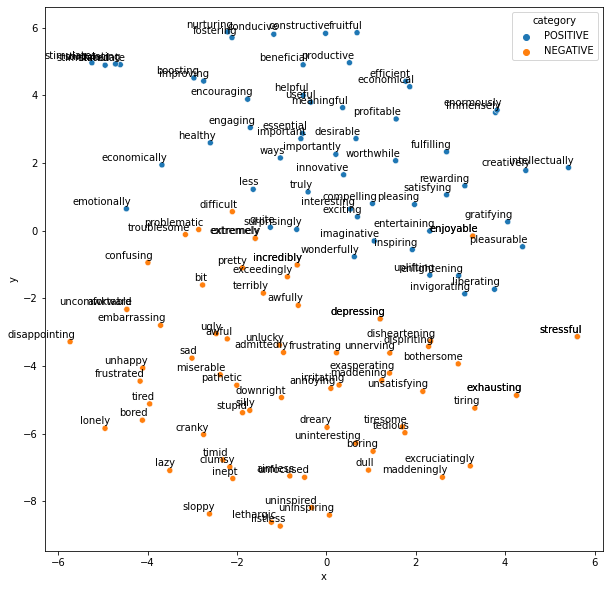

In [93]:
## plot
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(data=df_target, x="x", y="y", hue="category", ax=ax)


# ax.set(xlabel=None, ylabel=None, xticks=[], xticklabels=[], 
#        yticks=[], yticklabels=[])
for i in range(len(df_target)):
    ax.annotate(df_target.index[i], 
               xy=(df_target["x"].iloc[i],df_target["y"].iloc[i]), 
               xytext=(5,2), textcoords='offset points', 
               ha='right', va='bottom')

## 12.3 Remove useless words

### 12.3.1 Remove words from dictionary

This is a pretty good cluster. Let's remove some words that are too close to each other and does not help with sentiment clustering

In [94]:
positive_exclude = ['quite','less','surprisingly','enormously','immensely','emotionally','depressing']
dict_clusters['POSITIVE'] = [ elem for elem in dict_clusters['POSITIVE'] if elem not in positive_exclude]



In [95]:
dict_clusters['POSITIVE']

['nurturing',
 'desirable',
 'stimulate',
 'ways',
 'uplifting',
 'satisfying',
 'creatively',
 'stimulating',
 'worthwhile',
 'compelling',
 'invigorating',
 'productive',
 'encouraging',
 'exciting',
 'economical',
 'rewarding',
 'fulfilling',
 'efficient',
 'pleasing',
 'gratifying',
 'profitable',
 'entertaining',
 'fostering',
 'improving',
 'wonderfully',
 'constructive',
 'conducive',
 'inspiring',
 'enjoyable',
 'helpful',
 'imaginative',
 'essential',
 'stimulates',
 'enlightening',
 'beneficial',
 'economically',
 'boosting',
 'intellectually',
 'stressful',
 'innovative',
 'meaningful',
 'pleasurable',
 'engaging',
 'useful',
 'incredibly',
 'truly',
 'important',
 'exhausting',
 'healthy',
 'stimulated',
 'extremely',
 'importantly',
 'liberating',
 'fruitful',
 'interesting']

In [96]:
negative_exclude = ['bit','enjoyable','incredibly','extremely','pretty','exceedingly', 'stressful']
dict_clusters['NEGATIVE'] = [ elem for elem in dict_clusters['NEGATIVE'] if elem not in negative_exclude]



### 12.3.2 Visualize

In [97]:
df_target['index'] = range(1, len(df_target) + 1)

In [98]:
df_target = df_target.reset_index().set_index('index')


In [99]:
df_target=df_target.rename(columns={'level_0':'words', 'categoty':'sentiment'})


In [100]:
df_target

words         x         y  category
index                                             
1          nurturing -2.208268  5.878348  POSITIVE
2          desirable  0.663275  2.726298  POSITIVE
3          stimulate -4.608739  4.910252  POSITIVE
4          immensely  3.784164  3.494031  POSITIVE
5               ways -1.028566  2.153477  POSITIVE
...              ...       ...       ...       ...
123    disheartening  2.332490 -3.258809  NEGATIVE
124        unfocused -0.486236 -7.286005  NEGATIVE
125            timid -2.312324 -6.770275  NEGATIVE
126      exceedingly -0.870947 -1.359424  NEGATIVE
127            bored -4.114395 -5.597504  NEGATIVE

[127 rows x 4 columns]

In [101]:
exclude_all = ['quite','less','surprisingly','enormously','immensely','emotionally', 'bit','enjoyable','incredibly','extremely','pretty','exceedingly']
df_target = df_target[~df_target['words'].isin(exclude_all)]

In [102]:
df_target = df_target.set_index('words') 


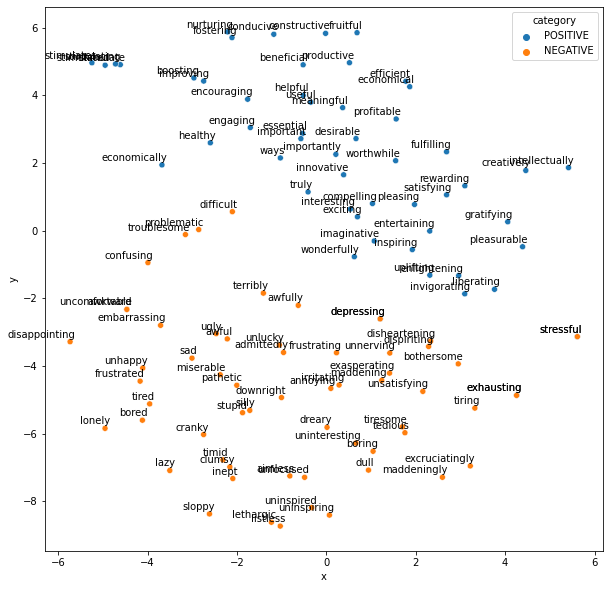

In [103]:
## plot
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(data=df_target, x="x", y="y", hue="category", ax=ax)


# ax.set(xlabel=None, ylabel=None, xticks=[], xticklabels=[], 
#        yticks=[], yticklabels=[])
for i in range(len(df_target)):
    ax.annotate(df_target.index[i], 
               xy=(df_target["x"].iloc[i],df_target["y"].iloc[i]), 
               xytext=(5,2), textcoords='offset points', 
               ha='right', va='bottom')

## 12.4 Create average embedding from our dict_clusters

In [104]:
dict_clusters

{'POSITIVE': ['nurturing',
  'desirable',
  'stimulate',
  'ways',
  'uplifting',
  'satisfying',
  'creatively',
  'stimulating',
  'worthwhile',
  'compelling',
  'invigorating',
  'productive',
  'encouraging',
  'exciting',
  'economical',
  'rewarding',
  'fulfilling',
  'efficient',
  'pleasing',
  'gratifying',
  'profitable',
  'entertaining',
  'fostering',
  'improving',
  'wonderfully',
  'constructive',
  'conducive',
  'inspiring',
  'enjoyable',
  'helpful',
  'imaginative',
  'essential',
  'stimulates',
  'enlightening',
  'beneficial',
  'economically',
  'boosting',
  'intellectually',
  'stressful',
  'innovative',
  'meaningful',
  'pleasurable',
  'engaging',
  'useful',
  'incredibly',
  'truly',
  'important',
  'exhausting',
  'healthy',
  'stimulated',
  'extremely',
  'importantly',
  'liberating',
  'fruitful',
  'interesting'],
 'NEGATIVE': ['awful',
  'exasperating',
  'awfully',
  'listless',
  'disappointing',
  'lazy',
  'unnerving',
  'ugly',
  'boring'

In [105]:
dict_own_embed = {}

for key, value_array in dict_clusters.items():
    # 1. concat the defining words in the array
    defining_words_arr = [' '.join(value_array)]
    
    # 2. encode this array
    defining_vector = model_sent.encode(defining_words_arr)
    
    #3. insert the resulting vector to our list
    dict_own_embed[key] = defining_vector
    print(dict_own_embed[key].shape)

(1, 768)
(1, 768)


In [106]:
dict_own_embed

{'POSITIVE': array([[-0.21255976,  0.13468327,  0.6193045 , -0.67777455, -0.17372549,
         -0.6396172 , -0.16975957, -0.49082533, -0.04753349, -0.3227967 ,
          0.54305303,  0.8854397 , -0.15552562, -0.4399231 , -0.38386843,
         -0.8704558 ,  1.7781291 ,  0.17877807, -1.270286  , -0.34027869,
          1.2169319 , -0.01163084,  0.05544282,  0.89923906, -0.30569723,
         -0.4347547 ,  1.2947924 ,  0.45495513,  0.47210217,  0.792544  ,
          0.03058598,  0.12488351, -0.72550255,  0.22146684, -0.43370762,
          0.5610302 ,  0.23428471, -0.5359882 ,  0.23591113, -0.5694356 ,
          0.51025504, -0.5588269 ,  1.100747  ,  0.57908434, -0.54971856,
          0.07164259, -1.1522381 ,  0.03498473, -0.92137706, -0.29196206,
         -0.21700618,  0.22643234, -0.3455014 , -0.2852337 ,  0.07666328,
          0.06973808, -1.2858661 ,  0.92365634,  2.1693447 , -1.1892924 ,
         -0.16360874,  0.1832991 , -0.29362231, -0.22421096,  0.7106956 ,
          0.04303442, -0.3

## 12.5 Save the average embedding as a df

In [107]:
#1. create df with two rows to store our +ve and -ve embedding
df_own_dict = pd.DataFrame(['positive_own','negative_own'])

In [108]:
#2. create the embedding column
df_own_dict['embedding'] = np.empty((len(df_own_dict), 768)).tolist()

In [109]:
#3. rename column
df_own_dict=df_own_dict.rename(columns={0:'sentiment'})


In [110]:
df_own_dict

sentiment                                          embedding
0  positive_own  [0.0, 3.94e-321, 0.0, 6.92927874539326e-310, 5...
1  negative_own  [2.3199938081590856e-57, 4.6652761186682985e-3...

In [111]:
#4. Assign value to the embedding column
df_own_dict.embedding.iloc[0] = dict_own_embed['POSITIVE'][0]
df_own_dict.embedding.iloc[1] = dict_own_embed['NEGATIVE'][0]

In [112]:
df_own_dict.to_json('df_own_dict.json')

In [113]:
df_own_dict

sentiment                                          embedding
0  positive_own  [-0.21255976, 0.13468327, 0.6193045, -0.677774...
1  negative_own  [-0.5539177, 0.014892185, 0.4784619, -0.522228...